# IV - Notebook : Implémentation & Design expérimental Monte Carlo

## Objectif
Implémenter les deux pricers — **Black–Scholes (analytique)** et **Monte Carlo (GBM sous mesure risque-neutre)** —  
puis exécuter les campagnes de **convergence** et de **sensibilité** prévues dans la spécification fonctionnelle.

Ce notebook contient :
1. L’implémentation des pricers.  
2. Les expériences Monte Carlo (convergence & sensibilité).  
3. Les visualisations inline (aucune sauvegarde de fichiers).


## 4.1 - Import et paramètres globaux

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import time

# Affichage inline uniquement
%matplotlib inline
def _blocked_savefig(*args, **kwargs):
    raise RuntimeError("plt.savefig est bloqué pour ce projet (affichage inline uniquement).")
plt.savefig = _blocked_savefig

# Paramètres globaux
SEED = 42
np.random.seed(SEED)
TRADING_DAYS = 252


## 4.2 Fonction black_scholes_price() 

**Explication :**
1) Calcule le prix théorique Black–Scholes d’une option européenne (call ou put).
2) Vérifie la validité des entrées (S, K, T, σ, option_type) et gère les cas limites (T = 0 ou σ = 0).
3) Applique les formules analytiques de Black–Scholes à partir de d₁ et d₂.
4) Retourne le prix actualisé sous la mesure risque-neutre.


**Pourquoi nous avons fait cela :** 
1) Fournir une référence analytique exacte pour comparer les résultats Monte Carlo.
2) Assurer la robustesse numérique grâce aux validations et cas limites.
3) Garantir la reproductibilité et la cohérence du pricing dans tous les notebooks.
4) Servir de base de vérification pour les tests de convergence et l’analyse des Greeks.

In [2]:
def black_scholes_price(S: float, K: float, T: float, r: float, sigma: float, option_type: str) -> float:
    """
    Prix Black–Scholes pour options européennes (call / put).
    Hypothèses : volatilité constante, pas de dividendes, mesure risque-neutre.
    """
    # ---- Validations ----
    if S <= 0: raise ValueError("S must be > 0")
    if K <= 0: raise ValueError("K must be > 0")
    if T < 0: raise ValueError("T must be >= 0")
    if sigma < 0: raise ValueError("sigma must be >= 0")
    if option_type not in {"call", "put"}:
        raise ValueError("option_type must be 'call' or 'put'")

    # ---- Cas limites ----
    if T == 0:
        return max(S - K, 0.0) if option_type == "call" else max(K - S, 0.0)
    if sigma == 0:
        ST = S * np.exp(r * T)
        payoff = max(ST - K, 0.0) if option_type == "call" else max(K - ST, 0.0)
        return np.exp(-r * T) * payoff

    # ---- Formules analytiques ----
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return float(price)


## 4.3 Fonction mc_option_price() 

**Explication :**
1) Calcule le prix d’une option européenne par simulation Monte Carlo sous la mesure risque-neutre.
2) Vérifie la validité des paramètres d’entrée et gère les cas limites (T = 0, σ = 0).
3) Génère n_sims variables normales Z pour simuler le prix final
4) Calcule les payoffs actualisés, puis renvoie le prix moyen et, si demandé, l’erreur-type (return_std=True).


**Pourquoi nous avons fait cela :** 
1) Fournir une méthode numérique de pricing indépendante de la formule analytique.
2) Permettre de tester la convergence du Monte Carlo vers le modèle Black–Scholes.
3) Évaluer la variabilité statistique du pricer via l’erreur-type.
4) Offrir une base flexible pour étendre le code à d’autres modèles stochastiques (vols locales, path-dependant).

In [3]:
def mc_option_price(S: float, K: float, T: float, r: float, sigma: float,
                    option_type: str, n_sims: int,
                    rng_seed: int | None = None,
                    return_std: bool = False):
    """
    Pricing Monte Carlo sous mesure risque-neutre.
    Retourne le prix moyen actualisé (et l'erreur-type si return_std=True).
    """
    # ---- Validations ----
    if S <= 0: raise ValueError("S must be > 0")
    if K <= 0: raise ValueError("K must be > 0")
    if T < 0: raise ValueError("T must be >= 0")
    if sigma < 0: raise ValueError("sigma must be >= 0")
    if option_type not in {"call", "put"}:
        raise ValueError("option_type must be 'call' or 'put'")
    if n_sims < 1: raise ValueError("n_sims must be >= 1")

    # ---- Seed ----
    if rng_seed is not None:
        np.random.seed(rng_seed)

    # ---- Cas limites ----
    if T == 0:
        payoff = max(S - K, 0.0) if option_type == "call" else max(K - S, 0.0)
        return payoff if not return_std else (payoff, 0.0)
    if sigma == 0:
        ST = S * np.exp(r * T)
        payoff = max(ST - K, 0.0) if option_type == "call" else max(K - ST, 0.0)
        price = np.exp(-r * T) * payoff
        return price if not return_std else (price, 0.0)

    # ---- Simulation ----
    Z = np.random.randn(n_sims)
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

    payoffs = np.maximum(ST - K, 0.0) if option_type == "call" else np.maximum(K - ST, 0.0)
    discounted = np.exp(-r * T) * payoffs

    mean_price = discounted.mean()
    std_hat = discounted.std(ddof=1) / np.sqrt(n_sims)

    return (mean_price, std_hat) if return_std else mean_price


## 4.4 Étude de convergence Monte Carlo → Black–Scholes

**Explication :**
1) On définit les paramètres de base :
2) On crée une liste de tailles d’échantillons (n_sims_list) pour tester la convergence statistique du Monte Carlo.
3) Pour chaque N, on calcule le prix MC (avec écart-type) et le prix analytique BS, puis on mesure l’erreur absolue, l’erreur relative et l’intervalle de confiance à 95 %.
4) On stocke tous les résultats (prix, erreurs, temps d’exécution) dans un DataFrame df_conv pour analyse et visualisation.


**Pourquoi nous avons fait cela :** 
1) Vérifier la convergence empirique du pricer Monte Carlo vers la valeur théorique Black–Scholes.
2) Quantifier la précision et la stabilité du Monte Carlo en fonction du nombre de simulations.
3) Illustrer la relation O(1/√N) typique de la variance du MC.
4) Créer une base structurée (df_conv) pour produire les graphes de convergence et comparer les performances.

In [4]:
# --- Paramètres de base ---
S0, K, r, sigma0, T0 = 100, 100, 0.05, 0.2, 1.0
n_sims_list = [10**2, 10**3, 5*10**3, 10**4, 5*10**4]

results = []
for n in n_sims_list:
    start = time.time()
    mc_mean, mc_std = mc_option_price(S0, K, T0, r, sigma0, "call", n, rng_seed=SEED, return_std=True)
    bs_price = black_scholes_price(S0, K, T0, r, sigma0, "call")
    elapsed = time.time() - start
    erreur = mc_mean - bs_price
    erreur_rel = abs(erreur) / bs_price
    ic95 = 1.96 * mc_std
    results.append([n, mc_mean, bs_price, erreur, erreur_rel, ic95, elapsed])

df_conv = pd.DataFrame(results, columns=["n_sims","prix_MC","prix_BS","erreur","erreur_rel","IC95","temps_exec"])
df_conv


,n_sims,prix_MC,prix_BS,erreur,erreur_rel,IC95,temps_exec
0,100,8.159991,10.450584,-2.290592,0.219183,2.309455,0.001030
1,1000,10.516569,10.450584,0.065986,0.006314,0.927003,0.000000
2,5000,10.485018,10.450584,0.034434,0.003295,0.406819,0.001508
3,10000,10.450170,10.450584,-0.000414,0.000040,0.289713,0.001082
4,50000,10.446164,10.450584,-0.004419,0.000423,0.128729,0.003301


## 4.5 Graphique 

**Graphique 1:**
- Le prix estimé par Monte Carlo se rapproche rapidement du prix théorique Black–Scholes.
- Pour un faible nombre de simulations, le résultat est bruité et sous-estime la valeur réelle.
- Dès 1 000 simulations, la différence devient très faible.
- Au-delà de 10 000, la convergence est stable, confirmant la fiabilité du pricer.

**Graphique 2:**
- L’erreur relative diminue fortement quand le nombre de simulations augmente.
- L’erreur relative diminue fortement quand le nombre de simulations augmente.
- L’amélioration devient marginale au-delà de quelques milliers de tirages.
- On observe le comportement typique attendu d’un pricer Monte Carlo bien implémenté.


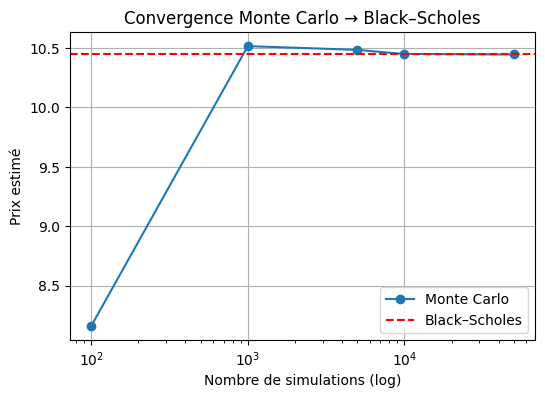

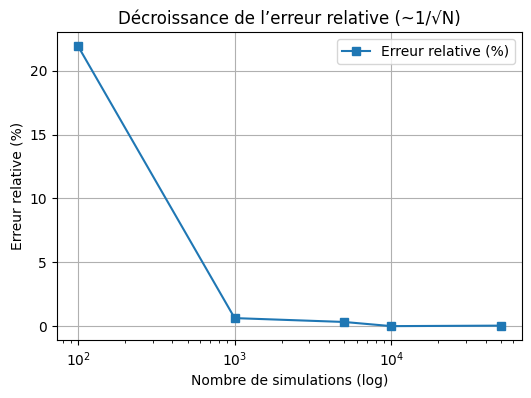

In [5]:
# --- Convergence Monte Carlo ---
plt.figure(figsize=(6,4))
plt.plot(df_conv["n_sims"], df_conv["prix_MC"], "o-", label="Monte Carlo")
plt.axhline(df_conv["prix_BS"].iloc[0], color="red", linestyle="--", label="Black–Scholes")
plt.xscale("log")
plt.xlabel("Nombre de simulations (log)")
plt.ylabel("Prix estimé")
plt.title("Convergence Monte Carlo → Black–Scholes")
plt.legend()
plt.grid(True)
plt.show()

# --- Erreur relative ---
plt.figure(figsize=(6,4))
plt.plot(df_conv["n_sims"], 100*df_conv["erreur_rel"], "s-", label="Erreur relative (%)")
plt.xscale("log")
plt.ylabel("Erreur relative (%)")
plt.xlabel("Nombre de simulations (log)")
plt.title("Décroissance de l’erreur relative (~1/√N)")
plt.grid(True)
plt.legend()
plt.show()
